# Homework II

### **IMPORTANT NOTICE:** COMMENTS ARE BRIEF. FULL EXPLANATION IS AVAILABLE IN THE REPORT.

## Exercise I

Study a single particle performing
a continuous-time random walk in the network described by the graph

In [24]:
# import useful libraries

import numpy as np
import networkx as nx
import scipy.io
import cvxpy as cp
import matplotlib.pyplot as plt
%matplotlib inline

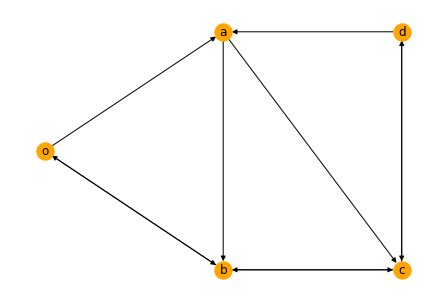

In [25]:
# Create and plot the graph

G = nx.DiGraph()
G.add_edges_from([('o', 'b'), ('o','a'), ('a','b'), ('a','c'), ('c','b'),
                  ('c','d'), ('d','a'), ('d','c'), ('b', 'o'), ('b', 'c')])
pos = {'o':[-1,0], 'a':[0,1], 'b':[0,-1], 'd':[1,1], 'c': [1,-1]}
nx.draw(G, pos, node_color='orange', with_labels=True)


# Define the transition-rate matrix

transition_rate = np.array([[0,   2/5, 1/5, 0,   0],
                            [0,   0,   3/4, 1/4, 0],
                            [1/2, 0,   0,   1/2, 0],
                            [0,   0,   1/3, 0,   2/3],
                            [0,   1/3, 0,   1/3, 0]])

dic={'o':0, 'a':1, 'b':2, 'c':3, 'd':4}
nodes = len(G.nodes)

In [26]:
def setup(transition_rate):

  # Rate of the poisson clock
  w=np.sum(transition_rate, axis=1)
  w_star=np.max(w)

  # Transition probabilities
  P_bar = transition_rate/ w_star 
  p = np.ones(5) - np.sum(P_bar, axis=1)
  P_bar += np.diag(p) # different definition for diagonal entries

  return w, w_star, P_bar


### Part 1

### a) What is, according to the simulations, the average time it takes a particle that starts in node a to leave the node and then return to it?


In [27]:
# Define matrices we and vectors we need
w, w_star, P_bar = setup(transition_rate)

# Define function for simulation
def simulation(n_simulations, n_steps, start, end, w_star, P_bar, dic):

  nodes = list(dic.values())
  array_return_time = np.zeros(n_simulations)
  t_next = -np.log(np.random.rand())/w_star 

  for j in range(n_simulations):
    exit=False
    pos = np.zeros(n_steps, dtype=int)
    pos[0] = dic[start] # 'a' is 1st node
    transition_times = np.zeros(n_steps)

    for i in range(1,n_steps):
      if exit==False: #particle has not reached end yet, continue random walk to a new position
        row = P_bar[pos[i-1], :]
        pos[i]=np.random.choice(nodes,p=row)
        transition_times[i] = transition_times[i-1] + t_next
        t_next = -np.log(np.random.rand())/ w_star
        if i>1 and pos[i] == dic[end]: #the particle has reached end node
          exit = True
      else: 
        break
    array_return_time[j] = transition_times[i-1]
    
  avg = np.mean(array_return_time)
  print(f'On average it takes the particle {round(avg,3)} s to go from node {start} to node {end}')

# Perform simulation
n_simulations, n_steps, start, end = 10000, 500, 'a', 'a'
avg_time = simulation(n_simulations, n_steps, start, end, w_star, P_bar, dic)

On average it takes the particle 6.767 s to go from node a to node a


### b) How does the result in a) compare to the theoretical return-time Ea[T+a]? (Include a description of how this is computed.)

In [28]:
# Define matrices we and vectors we need

L = np.diag(w) - transition_rate
eigenval, eigenvec = np.linalg.eig(L.T)
idx = [i for i in range(len(eigenval)) if np.isclose(eigenval[i],0)][0] #check if real part is close to 0
pi = eigenvec[:, idx].real
pi=pi/np.sum(pi)
print(f'pi_bar is {np.around(pi, decimals=3)}')
exp_time = 1/(pi*w) #vector of expected times
exp_time=np.around(exp_time, decimals=3)
print(f'Expected return times: {exp_time}')
print(f'The expected return time for node {start} is {round(exp_time[dic[start]],3)} s') 


pi_bar is [0.18518519 0.14814815 0.22222222 0.22222222 0.22222222]
Expected return times: [9.   6.75 4.5  4.5  6.75]
The expected return time for node a is 6.75 s


### c) What is, according to the simulations, the average time it takes to move from node o to node d?



In [29]:
n_simulations, n_steps, start, end = 10000, 500, 'o', 'd'
avg_time = simulation(n_simulations, n_steps, start, end, w_star, P_bar, dic)

On average it takes the particle 8.82 s to go from node o to node d


### d) How does the result in c) compare to the theoretical hitting-time Eo[Td]? (Describe also how this is computed.)

In [30]:
# Define matrices we and vectors we need
S = [dic['d']]
R = [node for node in range(nodes) if node not in S]

len_R = nodes - len(S)
b = np.ones(len_R)/w[R]

W=transition_rate
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W


A = np.identity(len_R)-P[np.ix_(R, R )]
x = np.linalg.solve(A,b)

hitting_s = np.zeros(nodes)
hitting_s[R] = x
hitting_s=np.around(hitting_s, decimals=3)
print(f'Expected hitting times for nodes: {hitting_s}')

# Compute theoretical return time vector
print(f'The expected hitting time for node {end} starting from {start} is {hitting_s[dic[start]]} s')

Expected hitting times for nodes: [8.786 7.143 7.071 3.357 0.   ]
The expected hitting time for node d starting from o is 8.786 s


## Part 2

### e) Interpret the matrix Λ as the weight matrix of a graph G = (V, E,Λ), and simulate the FrenchDeGroot dynamics on G with an arbitrary initial condition x(0). Does the dynamics converge to a consensus state? Motivate your answer.

In [31]:
'''
Define function to check if graph is aperiod and strongly connected.
If it is then we are certain that there is convergence to a consensus
Note: rand returns random values in [0,1], i.e. uniform distribution
'''

def French_DeGroot(G,x,W, n_iterations, byPass):

  if (nx.is_strongly_connected(G) and nx.is_aperiodic(G)) or byPass==True:
    print(f"Initial state is: {np.around(x, decimals=3)}")
    degrees = np.sum(W,axis=1)
    D = np.diag(degrees)
    P = np.linalg.inv(D) @ W

    # Simulate French-De Groot model

    for iter in range(n_iterations):
        x = P @ x

    print(f'After {n_iterations} iterations we reach x = {np.around(x, decimals=3)}')

  else:
    print(f'G is not aperiod and strongly connected.')


def consensus(G,x_0,W, byPass):
  
  if (nx.is_strongly_connected(G) and nx.is_aperiodic(G)) or byPass==True:
    print(f"Initial state is: {np.around(x_0, decimals=3)}")
    degrees = np.sum(W,axis=1)
    D = np.diag(degrees)
    P = np.linalg.inv(D) @ W

    # Find consensus value

    eigenval, eigenvec = np.linalg.eig(P.T)

    for index in [i for i in range(len(G)) if np.isclose(eigenval[i],1)]: 
      pi = eigenvec[:,index].real
      pi = pi/np.sum(pi)
    
    consensus = pi.T @ x_0
    print(f'pi is {np.around(pi, decimals=3)}')
    print(f'The opinions converge to the consensus {round(consensus,3)}')

  else:
    print(f'G is not aperiod and strongly connected.')

x_0 = np.random.rand(nodes)
W = transition_rate
n_simulations, n_steps = 10000, 500
French_DeGroot(G,x_0,W,n_steps, False)
consensus(G,x_0,W, False)

Initial state is: [0.375 0.724 0.797 0.637 0.981]
After 500 iterations we reach x = [0.719 0.719 0.719 0.719 0.719]
Initial state is: [0.375 0.724 0.797 0.637 0.981]
pi is [0.13  0.174 0.261 0.261 0.174]
The opinions converge to the consensus 0.719


### f) Assume that the initial state of the dynamics for each node is given by $x_i(0) = 𝜀_i$ where $(𝜀_i)_{i ϵV}$ are i.i.d random variables with variance $\sigma^2$. Compute the variance of the consensus value, and compare your results with numerical simulations.

In [32]:
# start with random initial states and run the dynamics

def variance_consensus(n_simulations, n_iterations, nodes, P, G, byPass):
  
  if (nx.is_strongly_connected(G) and nx.is_aperiodic(G)) or byPass==True:

    mean, sigma = 1/2, 1/12
    print(f"Initial variance of the node states: {round(sigma,3)}") 

    # Theoretical results
    eigenval, eigenvec = np.linalg.eig(P.T)
    for index in [i for i in range(len(G)) if np.isclose(eigenval[i],1)]: 
      pi = eigenvec[:,index].real
      pi = pi/np.sum(pi)
    pi_square=np.square(pi)
    sigma_crowd=sigma*np.sum(pi_square) #crowd level
    print(f"Theoretical Variance of the consensus state: {round(sigma_crowd,3)}")

    sigma_simulations=[]
    for i in range(n_simulations):
      x = np.random.rand(nodes)
      for n in range(n_iterations):
          x = P @ x
      sigma_simulations.append((1/2 - np.mean(x))*(1/2 - np.mean(x)))  
    #print("Expected variance of the node states:", 1/12)
    print(f"Empirical variance of the consensus state: {round(np.mean(sigma_simulations),3)}")

  else:
    print(f'G is not aperiod and strongly connected.')

variance_consensus(n_simulations, n_steps, nodes, P, G, False)

Initial variance of the node states: 0.083
Theoretical Variance of the consensus state: 0.018
Empirical variance of the consensus state: 0.018


### g) Remove the edges (d; a) and (d; c). Describe and motivate the asymptotic behaviour of the dynamics. If the dynamics converges to a consensus state, how is the consensus value related to the initial condition $x(0)$?

### Assume that the initial state of the dynamics for each node $i \in V$ is given by $xi(0) = ε_i$, where $\{ε_{i}\}_{i \in V}$ are i.i.d random variables with variance $\sigma^2$. Compute the variance of the consensus value. Motivate your answer.

Initial state is: [0.375 0.724 0.797 0.637 0.981]
After 500 iterations we reach x = [0.981 0.981 0.981 0.981 0.981]
Initial state is: [0.375 0.724 0.797 0.637 0.981]
pi is [0. 0. 0. 0. 1.]
The opinions converge to the consensus 0.981
----
Initial variance of the node states: 0.083
Theoretical Variance of the consensus state: 0.083
Empirical variance of the consensus state: 0.084


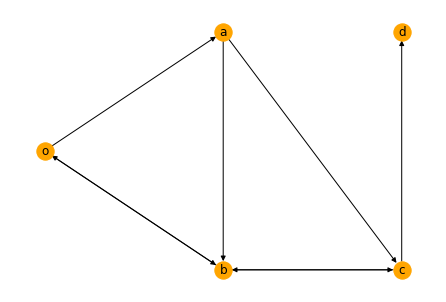

In [33]:
# define function to reset transition_rate matrix since we will tamper with it

def reset(transition_matrix):
  transition_rate = np.array([[0,   2/5, 1/5, 0,   0],
                            [0,   0,   3/4, 1/4, 0],
                            [1/2, 0,   0,   1/2, 0],
                            [0,   0,   1/3, 0,   2/3],
                            [0,   1/3, 0,   1/3, 0]])
  return transition_rate

# Update data and matrices
G1 = nx.DiGraph()
G1.add_edges_from([('o', 'b'), ('o','a'), ('a','b'), ('a','c'), ('c','b'),
                  ('c','d'), ('b', 'o'), ('b', 'c')])
pos = {'o':[-1,0], 'a':[0,1], 'b':[0,-1], 'd':[1,1], 'c': [1,-1]}
nx.draw(G1, pos, node_color='orange', with_labels=True)

to_remove = [('d','a'),('d','c')]
transition_rate=reset(transition_rate)
for el in to_remove:
    transition_rate[dic[el[0]]][dic[el[1]]]=0 
transition_rate[4][4] = 1 #add self loop 
W=transition_rate                      
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

# Abalyse French-DeGroot Dynamics 
French_DeGroot(G1,x_0,W,n_steps, True)
consensus(G1,x_0,W,True)
print("----")
variance_consensus(n_simulations, n_steps, nodes, P, G1, True)

### h) Consider the graph (V; E; Λ), and remove the edges (c; b) and (d; a). Analyse the French-DeGroot dynamics on the new graph. In particular, describe and motivate the asymptotic behaviour of the dynamics in terms of the initial condition x(0).

Initial state is: [0.375 0.724 0.797 0.637 0.981]
After 500 iterations we reach x = [0.795 0.782 0.901 0.637 0.981]
Initial state is: [0.375 0.724 0.797 0.637 0.981]
pi is [0.  0.  0.  0.5 0.5]
The opinions converge to the consensus 0.809
Initial state is: [0.293 0.282 0.92  0.948 0.948]
After 500 iterations we reach x = [0.948 0.948 0.948 0.948 0.948]
Initial state is: [0.293 0.282 0.92  0.948 0.948]
pi is [0.  0.  0.  0.5 0.5]
The opinions converge to the consensus 0.948


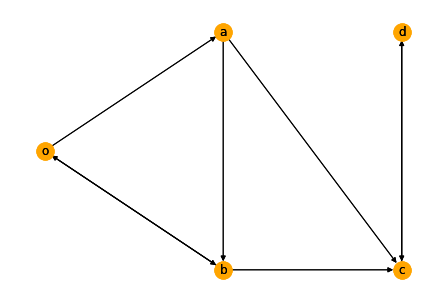

In [34]:
# Update data and matrices

G2 = nx.DiGraph()
G2.add_edges_from([('o', 'b'), ('o','a'), ('a','b'), ('a','c'),
                  ('c','d'), ('d','c'), ('b', 'o'), ('b', 'c')])
pos = {'o':[-1,0], 'a':[0,1], 'b':[0,-1], 'd':[1,1], 'c': [1,-1]}
nx.draw(G2, pos, node_color='orange', with_labels=True)

to_remove = [('c','b'),('d','a')]
G2 = G
G2.remove_edges_from(to_remove)
nx.draw(G2, pos, node_color='orange', with_labels=True)
transition_rate=reset(transition_rate)
for el in to_remove:
    transition_rate[dic[el[0]]][dic[el[1]]]=0
W=transition_rate     
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

# Analyse French-DeGroot Dynamics
# We force the algorithm by using byPass=True eventhogh we know that it will not converge since the sink component given by {c,d} is not aperiodic
French_DeGroot(G2,x_0,W,n_steps, True) 
consensus(G2,x_0,W, True)

# Show that there is consensus if initial opinion of c is equal to that of d
x_0=[0.293, 0.282, 0.92,  0.948, 0.948]
French_DeGroot(G2,x_0,W,n_steps, True) 
consensus(G2,x_0,W, True)

## Exercise II

### a)
* ### If 100 particles all start in node $a$, what is the average time for a particle to return to node $a$? 
* ### How does this compare to the answer in Problem 1, why?

In [35]:
# Define matrices we and vectors we need
transition_rate=reset(transition_rate)
w, w_star, P_bar = setup(transition_rate)

n_simulations, n_steps, start, end = 100, 500, 'a', 'a'
avg_time = simulation(n_simulations, n_steps, start, end, w_star, P_bar, dic)

On average it takes the particle 6.515 s to go from node a to node a


### b) 
*   ### If 100 particles start in node o, and the system is simulated for 60 time units, what is the average number of particles in the dierent nodes at the end of the simulation?
*   ### Illustrate the simulation above with a plot showing the number of particles in each node during the simulation time.
* ### Compare the simulation result in the first point above with the stationary distribution of the continuous-time random walk followed by the single particles.


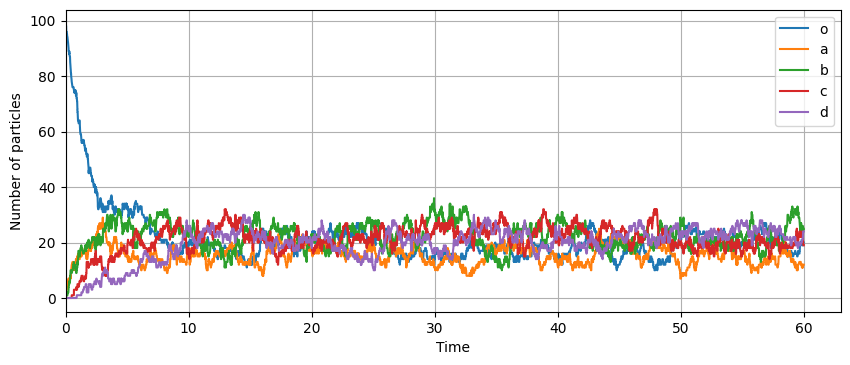

In [36]:
# Define function to plot trajectories of particles
def plot_traj(traj, times, style):
  nodes=['o', 'a', 'b', 'c', 'd']
  fig = plt.figure(figsize=(10,4), dpi=100)
  ax = plt.subplot(111)

  for node in range(traj.shape[1]):
    trajectory=traj[:,node]
    ax.plot(times, trajectory, style, label=nodes[node])

  plt.grid(linestyle='-')
  ax.legend()
  ax.set_xlim(0)
  plt.xlabel('Time')
  plt.ylabel('Number of particles')
  plt.show()


# Simulate a random walk starting in o for n_particles, lasting 'duration' seconds '
def node_perspective(P_bar, w_star, duration, n_particles, dic):
  trajectories, times = [], []
  nodes = {k:0 for k in list(dic.values())}
  nodes[0] = n_particles # at the beginning all particles are in node o (position 0)
  clock = 0

  '''
  We consider a global poisson clock of rate 100. When the clock ticks we randomly and proportionally to the
  number of particles in different nodes, chose a node in the graph and move 
  the particle from there according to transition probability matrix
  '''

  rate = w_star*n_particles
  while clock <= duration:
    clock += - np.log(np.random.uniform())/rate
    #chose a node
    prob = np.array(list(nodes.values()))/np.sum(list(nodes.values()))
    chosen_node = np.random.choice(list(nodes.keys()),p=prob)
    # move particle from chosen_node to a randomly selected new node (next_node)
    row = P_bar[chosen_node, :]
    next_node = np.random.choice(list(nodes.keys()), p=row)
    #adjust number of particles in nodes
    nodes[chosen_node]-=1
    nodes[next_node]+=1

    trajectories.append(list(nodes.values()))
    times.append(clock)
  
  return np.array(trajectories), np.array(times)

n_particles, duration = 100, 60
w, w_star, P_bar = setup(transition_rate)
traj, times = node_perspective(P_bar, w_star, duration, n_particles, dic)
plot_traj(traj, times, '-')

In [37]:
print(f'Number of particles in each node after 60 s: {traj[-1,:]}')
print(f'Invariant probability vector (scaled by a factor of 100): {np.around([100*el for el in pi],3)}' )


Number of particles in each node after 60 s: [20 12 25 19 24]
Invariant probability vector (scaled by a factor of 100): [18.519 14.815 22.222 22.222 22.222]


## Exercise III

### **a) Proportional rate**
### The rate of the Poisson clock of each node is equal to the number of particles in it.
* ### Simulate the system for 60 time units and plot the evolution of the number of particles in each node over time.
* ### What is the largest input rate that the system can handle without blowing up?

### **b) Fixed rate:**
### The rate of the Poisson clock of each node is fixed, and equal to one.
* ### Simulate the system for 60 time units and plot the evolution of number of particles in each node over time.
* ### What is the largest input rate that the system can handle without blowing up? Why is this different from the other case?

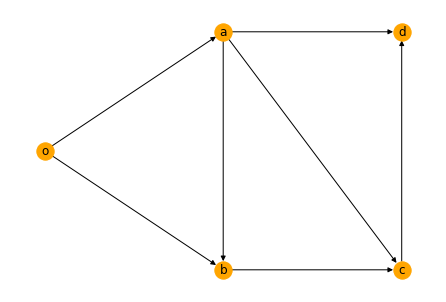

In [38]:
G = nx.DiGraph()
G.add_edges_from([('o', 'b'), ('o','a'), ('a','b'), ('a','c'), ('b', 'c'), ('a', 'd'), ('c', 'd')])
pos = {'o':[-1,0], 'a':[0,1], 'b':[0,-1], 'c': [1,-1], 'd':[1,1]}
nx.draw(G, pos, node_color='orange', with_labels=True)

# Define the transition-rate matrix 
transition_rate = np.array([
          [0,   2/3, 1/3, 0,   0],
          [0,   0,   1/4, 1/4, 2/4],
          [0,   0,   0,   1,   0],
          [0,   0,   0,   0,   1],
          [0,   0,   0,   0,   0]])

dic={'o':0, 'a':1, 'b':2, 'c':3, 'd':4}
nodes = len(G.nodes)

In [39]:
def entering_times(enter_rate, stop):
  t=0.0
  times=[]
  while t<=stop:
    t += -np.log(np.random.uniform())/enter_rate
    times.append(t)
  if times[-1]>stop:
    times.pop(-1)

  return times

In [40]:
def proportional(P_bar, w_star, start, end, stop_time, enter_rate):
  times = []
  trajectories = []
  nodes = {i:0 for i in range(P_bar.shape[0])}
  node_names=list(nodes.keys())
  entering_t=entering_times(enter_rate, stop_time) # list of entering times for each particle

  #First particle enters
  time = entering_t[0]
  entering_t.pop(0)

  while time <= stop_time:
    n=np.sum(list(nodes.values())) #number of particles in system

    if n>0: #global clock ticks
      rate = w_star*n
      time += -np.log(np.random.uniform()) / rate
    elif len(entering_t)>0: #move to time of entrance of next particle 
      time=entering_t[0]
    else:
      break

    if (len(entering_t)>0 and time<entering_t[0]) or len(entering_t)==0:
      # if it is not yet time for a particle to enter the system we move a particle to another node
      prob=np.array(list(nodes.values()))/np.sum(list(nodes.values())) #for each node number of particles at that node/ total number of particles in system
      chosen_node=np.random.choice(node_names, p=prob)

      if chosen_node==end: 
        nodes[end] -=1
      else: # move particle
        row=P_bar[chosen_node, :]
        next_node=np.random.choice(node_names, p=row)
        nodes[chosen_node]-=1
        nodes[next_node]+=1   
    
    else:
      #particle enters at node o
      time=entering_t[0]
      nodes[start]+=1
      entering_t.pop(0)

    trajectories.append(list(nodes.values()))
    times.append(time)

  return np.array(trajectories), times


In [41]:
def fixed(P_bar, w_star, start, end, stop_time, enter_rate):
  times = []
  trajectories = []
  nodes = {i:0 for i in range(P_bar.shape[0])}
  node_names=list(nodes.keys())
  entering_t=entering_times(enter_rate, stop_time) # list of entering times for each particle
  rate = w_star * P_bar.shape[0]

  #First particle enters
  time = entering_t[0]
  entering_t.pop(0)

  while time <= stop_time:

    time += -np.log(np.random.uniform()) / rate

    while len(entering_t) != 0 and time >= entering_t[0]:
      nodes[start] += 1
      trajectories.append(list(nodes.values()))
      times.append(entering_t[0])
      entering_t.pop(0)

    chosen_node=np.random.choice(node_names)

    if nodes[chosen_node]>0:
      if chosen_node == end:
        nodes[end] -=1
      else: # move particle
        row=P_bar[chosen_node, :]
        next_node=np.random.choice(node_names, p=row)
        nodes[chosen_node]-=1
        nodes[next_node]+=1   

    trajectories.append(list(nodes.values()))
    times.append(time)

  return np.array(trajectories), times


In [42]:
def run(transition_rate, start, end, dic, duration, entering_rate, type):
  w, w_star, P_bar = setup(transition_rate) 
  if type=="proportional":
    traj, times = proportional(P_bar, w_star, dic[start], dic[end], duration, entering_rate)
  else:
    traj, times = fixed(P_bar, w_star, dic[start], dic[end], duration, entering_rate)
  plot_traj(traj, times, 'o-')


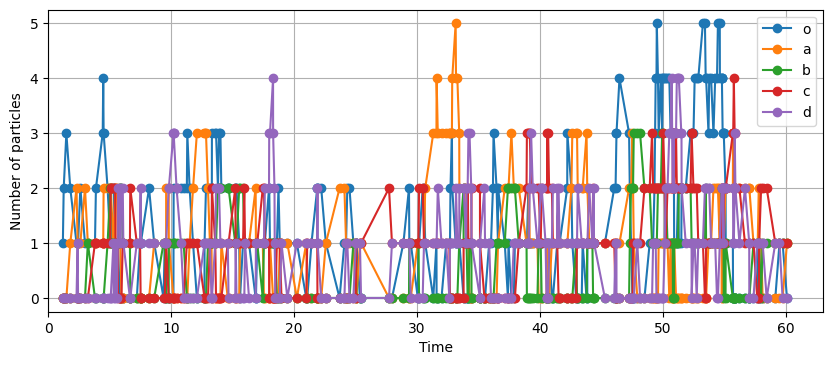

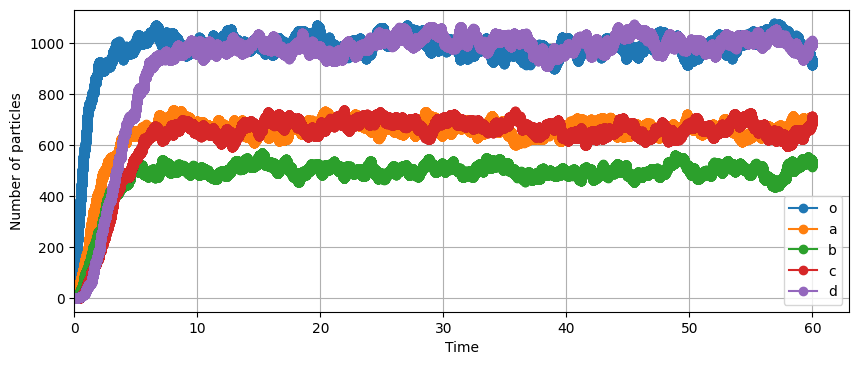

In [43]:
start, end, duration = 'o', 'd', 60

# Proportional
run(transition_rate, start, end, dic, duration, 1, 'proportional') # Case entering_rate = 1
run(transition_rate, start, end, dic, duration, 1000, 'proportional') # Case entering_rate = 10000


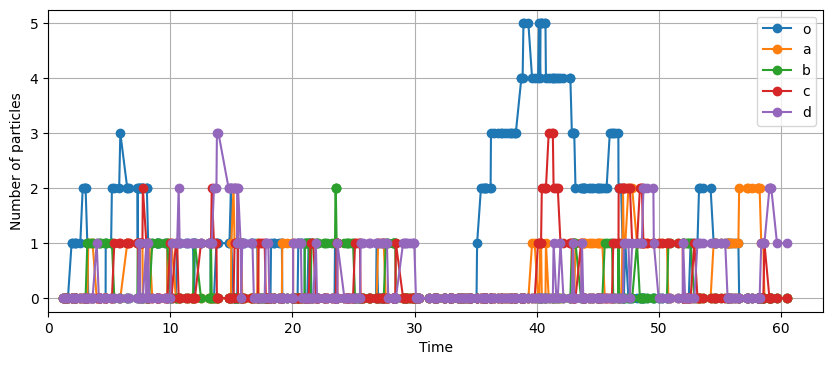

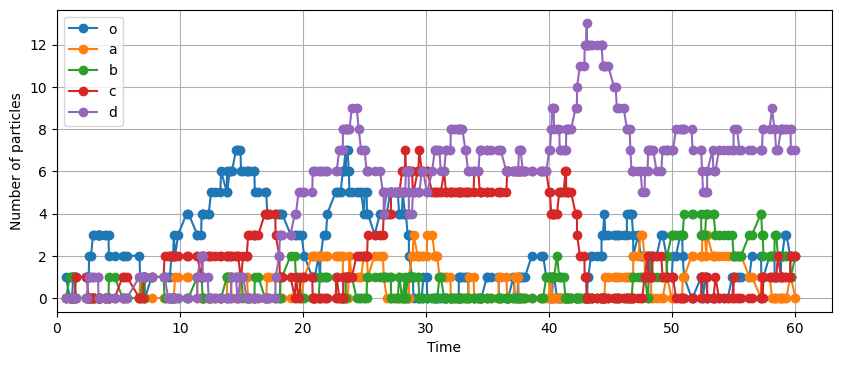

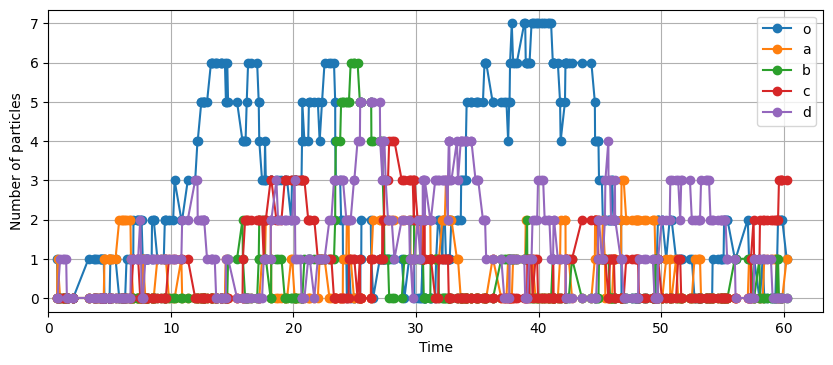

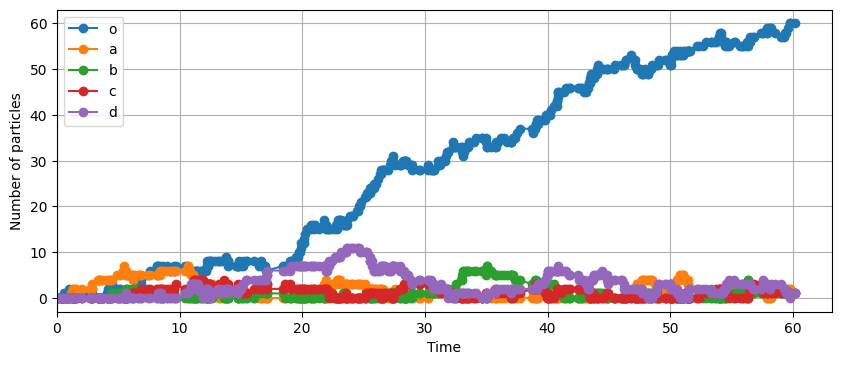

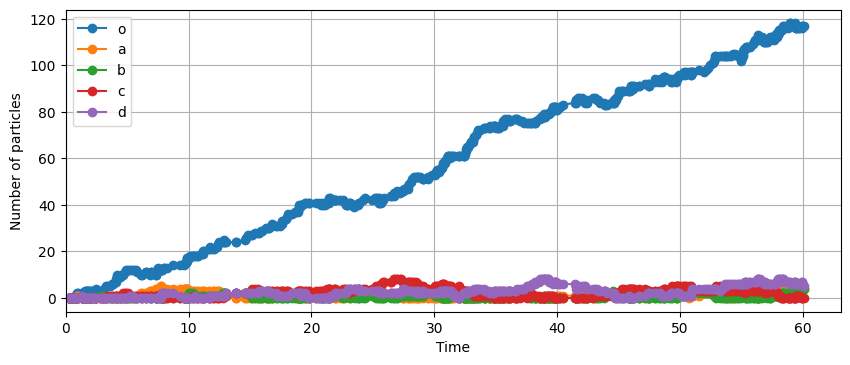

In [44]:
# Fixed
run(transition_rate, start, end, dic, duration, 0.5, 'fixed')
run(transition_rate, start, end, dic, duration, 0.7, 'fixed')
run(transition_rate, start, end, dic, duration, 1, 'fixed')
run(transition_rate, start, end, dic, duration, 2, 'fixed')
run(transition_rate, start, end, dic, duration, 3, 'fixed')